<Axes: >

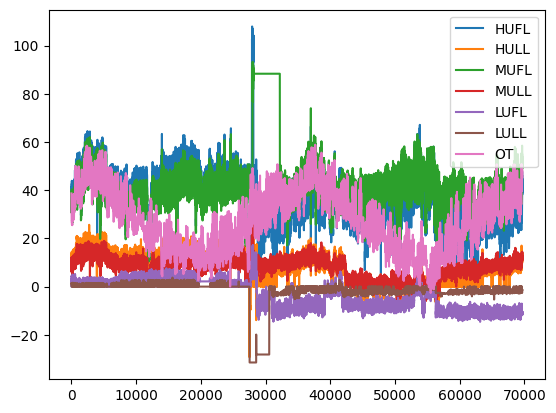

In [1]:
import pandas as pd 

df = pd.read_csv("ETTm2.csv")
df.plot()

In [2]:
df['date'] = pd.to_datetime(df['date'])
training_df = df[df['date'] < df['date'].min() + pd.DateOffset(months=12)]
val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]

/tmp/ipykernel_2117/2599488179.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
/tmp/ipykernel_2117/2599488179.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]


In [30]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,drop_cols,future_steps, p_lag=0):
        self.df = df.drop(drop_cols, axis=1)
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [22]:
val_data = DataLoader(TimeSeriesDataset(val_df,future_steps= 7, target_column = ['OT'],drop_cols='date',p_lag=5), batch_size=8)
net = ARNet(p_lag = 5, n_features = 7, future_steps = 7, batch_size=8)
dec = DecompositionLayer(7)

In [23]:
for i,t in val_data: 
    #print(i.shape)
    #season, trend = dec(i)
    #print(season.shape)
    net(i)

torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size([8, 1, 35])
torch.Size([8, 1, 35])
torch.Size([8, 18])
torch.Size

KeyboardInterrupt: 

In [31]:
import math
import torch.nn as nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 

    def forward(self, x):
        #print(x.shape)
        num_of_pads = (self.kernel_size - 1) // 2
        #print(num_of_pads)
        if self.kernel_size > 7: 
            front = x[:, 0:1, :].repeat(1, num_of_pads + 1, 1)
        else: 
            front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)
        #print(x_padded.shape)

        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        
        #print(x_trend.shape) # why do i loose one value if i increase decomp-size above 7
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7, batch_size = 8):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size)
        self.criterion = nn.MSELoss()
        self.p_lag = p_lag
        self.batch_size = batch_size

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input)
        x_season = self.input_seasonal_layer(input_season.reshape(self.batch_size, self.p_lag*7))
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend.reshape(self.batch_size, self.p_lag*7))
        y_hat_trend = self.output_trend_layer(x_trend)

        return y_hat_season + y_hat_trend

In [50]:
import numpy as np

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean() + 1e-12) ** 2))

def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse, corr

In [ ]:
# np_arr = torch_tensor.detach().cpu().numpy()

In [54]:
def train(epochs, p_lag, future_steps, training_df, validation_df, drop_cols = 'date', target_column = ['OT'], learning_rate=1.e-4, decomp_kernel_size= 7, batch_size = 8): 
    net = ARNet(p_lag=p_lag, n_features=7, future_steps=future_steps, decomp_kernel_size=decomp_kernel_size, batch_size=batch_size)

    train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    train_loss_list = []
    val_data = DataLoader(TimeSeriesDataset(validation_df,future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    val_loss_list = []

    torch.set_grad_enabled(True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    running_train_loss = 0.
    running_val_loss = 0.


    running_train_mae  = 0.
    running_train_mse  = 0.
    running_train_rmse = 0.
    running_train_mape = 0.
    running_train_mspe = 0.
    running_train_rse  = 0.
    running_train_corr = 0.

    running_val_mae  = 0.
    running_val_mse  = 0.
    running_val_rmse = 0.
    running_val_mape = 0.
    running_val_mspe = 0.
    running_val_rse  = 0.
    running_val_corr = 0.

    train_counter = 1
    val_counter = 1
    for epoch in range(epochs): 
        if epoch + 1 != 1: 
            learning_rate = learning_rate / 2
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        print(f"Current learning rate is : {learning_rate}")  
        print("---------------------------")
        for i, data in enumerate(train_data):
            inputs, labels = data
            labels = labels.squeeze(0).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = net.criterion(outputs, labels.squeeze(2))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()

            outputs_array = outputs.detach().cpu().numpy()
            labels_array = labels.squeeze(2).detach().cpu().numpy()
            mae, mse, rmse, mape, mspe, rse, corr = metric(pred=outputs_array, true=labels_array)
            running_train_mae  += mae
            running_train_mse  += mse
            running_train_rmse += rmse
            running_train_mape += mape
            running_train_mspe += mspe
            running_train_rse  += rse
            running_train_corr += corr

            running_train_loss += loss.item()

            train_counter += batch_size
            if train_counter % 10000 == 0: 
                print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

        train_loss_list.append(running_train_loss/train_counter)
            
        for i, data in enumerate(val_data):
            inputs, test_labels = data
            test_labels = test_labels.squeeze(0).float()
            output = net(inputs)
            val_loss = net.criterion(output, test_labels.squeeze(2))
            running_val_loss += val_loss.item()

            output_array = output.detach().cpu().numpy()
            test_labels_array = test_labels.squeeze(2).detach().cpu().numpy()
            mae, mse, rmse, mape, mspe, rse, corr = metric(pred=output_array, true=test_labels_array)
            running_val_mae  += mae
            running_val_mse  += mse
            running_val_rmse += rmse
            running_val_mape += mape
            running_val_mspe += mspe
            running_val_rse  += rse
            running_val_corr += corr

            val_counter += batch_size
        val_loss_list.append(running_val_loss/val_counter)


        if epoch % 1 == 0: 
            print(f"Epoch {epoch}: ")
            print(f"Running (training) loss(MSE) is {running_train_loss/train_counter}.")
            print(f"Training MAE is {running_train_mae/train_counter}.")
            print(f"Training MSE is {running_val_mse/train_counter}.")
            print(f"Training RMSE is {running_val_rmse/train_counter}.")
            print(f"Training MAPE is {running_train_mape/train_counter}.")
            print(f"Training MSPE is {running_val_mspe/train_counter}.")
            print(f"Training RSE is {running_val_rse/train_counter}.")
            print(f"Training CORR is {running_val_corr/train_counter}.")

            print(f"Running (validation) loss (MSE) is {running_val_loss/val_counter}.")
            print(f"Validation MAE is {running_train_mae/train_counter}.")
            print(f"Validation MSE is {running_val_mse/train_counter}.")
            print(f"Validation RMSE is {running_val_rmse/train_counter}.")
            print(f"Validation MAPE is {running_train_mape/train_counter}.")
            print(f"Validation MSPE is {running_val_mspe/train_counter}.")
            print(f"Validation RSE is {running_val_rse/train_counter}.")
            print(f"Validation CORR is {running_val_corr/train_counter}.")
            print("---------------------------")
    
    return net

In [55]:
p_lag = 72
future_steps = 1
batch_size = 8

peter = train(epochs = 8, 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            drop_cols='date', 
            learning_rate=1.e-4 ,
            decomp_kernel_size= 24, 
            batch_size=batch_size)

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],drop_cols='date',p_lag=p_lag), batch_size=batch_size,drop_last=True)

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.squeeze(0,1).tolist()} and true value is {labels.squeeze(1,2).tolist()}")
    if i > 1: 
        break

Current learning rate is : 0.0001
---------------------------


In [44]:
for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.squeeze(0,1).tolist()} and true value is {labels.squeeze(1,2).tolist()}")
    if i > 100: 
        break

predicted output is [31.584657669067383, 31.787813186645508, 31.867679595947266, 31.65322494506836, 31.479961395263672, 31.540735244750977, 31.466432571411133, 31.387060165405273] and true value is [32.290000915527344, 32.290000915527344, 31.63050079345703, 31.410999298095703, 31.410999298095703, 31.850500106811523, 31.850500106811523, 31.850500106811523]
predicted output is [31.5821590423584, 31.55943489074707, 31.671297073364258, 31.64557456970215, 31.717437744140625, 31.894441604614258, 31.987661361694336, 32.152679443359375] and true value is [31.850500106811523, 32.070499420166016, 32.070499420166016, 32.070499420166016, 32.290000915527344, 32.290000915527344, 32.290000915527344, 32.290000915527344]
predicted output is [32.20872116088867, 32.142948150634766, 32.361568450927734, 32.431575775146484, 32.27333450317383, 32.34218215942383, 32.39643859863281, 32.21751022338867] and true value is [32.290000915527344, 32.290000915527344, 32.290000915527344, 31.850500106811523, 31.41099929

In [28]:
#prediction for 100 steps in the case of only univariate time series
steps = 100
for i, data in enumerate(test_data): 
    input, _ = data
    prediction = net(input)
    new_input = torch.cat([input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])
    for _ in range(steps): 
        prediction = net(new_input)
        new_input = torch.cat([new_input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])   
    new_input

KeyboardInterrupt: 

In [45]:
#iterative prediction for 100 steps in the case of only multivariate time series
# we assume full knowledge of covariates at each time 
steps = 1000
prediction_list = []
target_list = []
for i, data in enumerate(test_data): 
    input, target = data
    prediction = net(input)
    prediction_list.append(prediction.squeeze(0).item())
    target_list.append(target.squeeze(0).item())
    if i == (steps -1): 
        break
    new_input

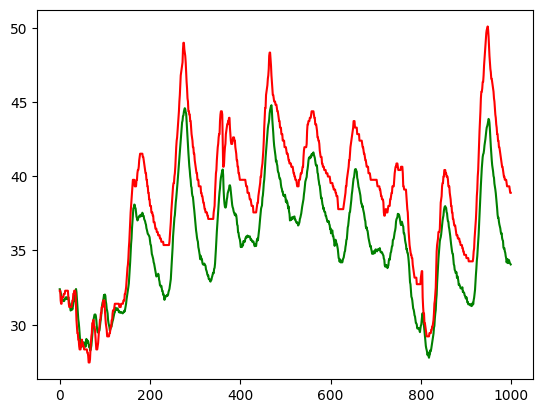

In [46]:
import matplotlib.pyplot as plt
plt.plot(prediction_list, 'g', target_list, 'r')
plt.show()